# 1. Análise Exploratória e Tratamento de Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Carregar dados
df = pd.read_csv('telemetria_track_care_treino.csv')

print("=" * 80)
print("ANÁLISE EXPLORATÓRIA INICIAL")
print("=" * 80)
print(f"\n📦 Shape do Dataset: {df.shape}")
print(f"\n📋 Colunas: {df.columns.tolist()}")
print(f"\n📊 Tipos de Dados:\n{df.dtypes}")
print(f"\n🔍 Valores Nulos:\n{df.isnull().sum()}")

ANÁLISE EXPLORATÓRIA INICIAL

📦 Shape do Dataset: (5000, 8)

📋 Colunas: ['timestamp', 'patient_id', 'imei', 'employee_id', 'sensor_latlong', 'sensor_room', 'rssi', 'actual_patient_room']

📊 Tipos de Dados:
timestamp               object
patient_id              object
imei                    object
employee_id             object
sensor_latlong          object
sensor_room             object
rssi                   float64
actual_patient_room     object
dtype: object

🔍 Valores Nulos:
timestamp              0
patient_id             0
imei                   0
employee_id            0
sensor_latlong         0
sensor_room            0
rssi                   0
actual_patient_room    0
dtype: int64



1. ANÁLISE DE RSSI POR IMEI (VARIAÇÃO DE HARDWARE)

📱 Estatísticas de RSSI por IMEI:
                   mean    std     min    max  count
imei                                                
IMEI_999999      -79.94   8.76  -99.28 -60.77     75
IMEI_IPHONE_X    -74.09  12.17 -115.00  14.70   1655
IMEI_MOTO_G_OLD  -88.37  14.63 -115.00  13.28   1607
IMEI_SAMSUNG_S23 -80.63  13.68 -115.00  12.81   1663

⚠️  IMEI_999999 (FAKE): 75 amostras


<Figure size 1400x600 with 0 Axes>

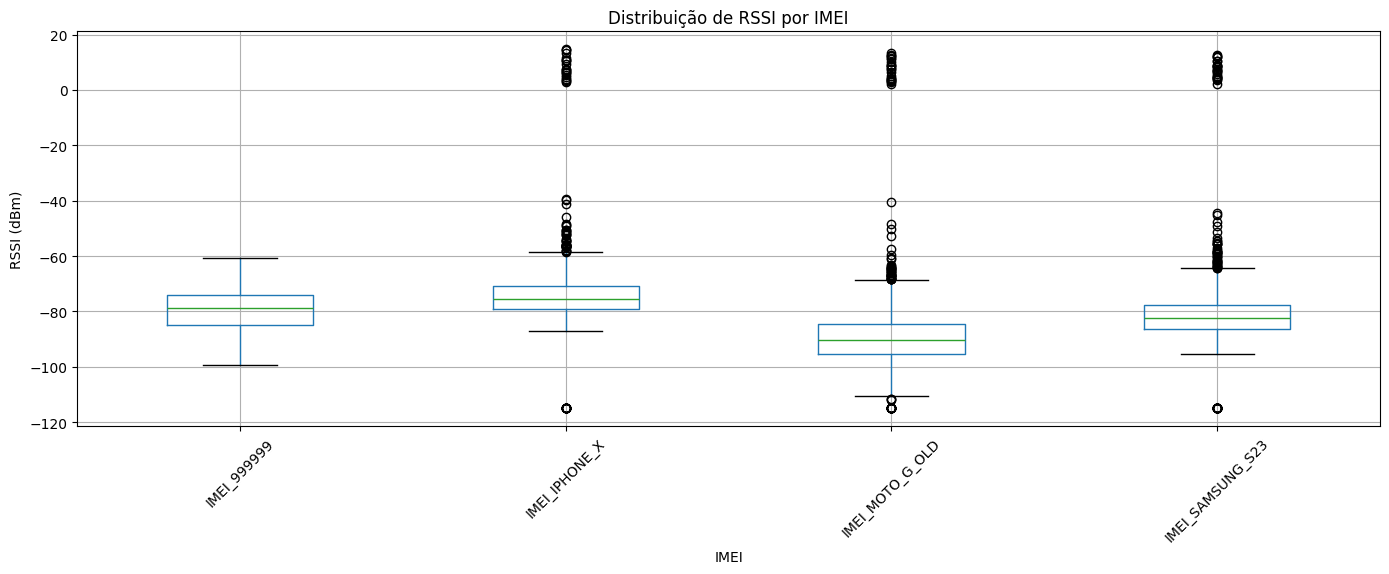

In [2]:
# ============================================================================
# 1. IDENTIFICAÇÃO E TRATAMENTO DE OUTLIERS
# ============================================================================

print("\n" + "=" * 80)
print("1. ANÁLISE DE RSSI POR IMEI (VARIAÇÃO DE HARDWARE)")
print("=" * 80)

# Análise de RSSI por IMEI
imei_stats = df.groupby('imei')['rssi'].agg(['mean', 'std', 'min', 'max', 'count']).round(2)
print(f"\n📱 Estatísticas de RSSI por IMEI:\n{imei_stats}")

# Identificar IMEI fake (999999)
fake_imei_count = df[df['imei'] == 'IMEI_999999'].shape[0]
print(f"\n⚠️  IMEI_999999 (FAKE): {fake_imei_count} amostras")

# Visualizar distribuição de RSSI por IMEI
plt.figure(figsize=(14, 6))
df.boxplot(column='rssi', by='imei', figsize=(14, 6))
plt.title('Distribuição de RSSI por IMEI')
plt.suptitle('')
plt.xlabel('IMEI')
plt.ylabel('RSSI (dBm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rssi_by_imei.png', dpi=150)
plt.show()

In [3]:
# ============================================================================
# 2. IDENTIFICAÇÃO DE RUÍDOS E OUTLIERS
# ============================================================================

print("\n" + "=" * 80)
print("2. IDENTIFICAÇÃO DE RUÍDOS NO RSSI")
print("=" * 80)

# RSSI fisicamente impossível (valores positivos extremos ou muito baixos)
# RSSI típico BLE: -100 a -20 dBm
# Valores > 0 ou < -120 são suspeitos

outliers_positive = df[df['rssi'] > 0]
outliers_extreme = df[df['rssi'] < -120]

print(f"\n🔴 RSSI Positivo (Fisicamente Impossível): {len(outliers_positive)} amostras")
print(f"🔴 RSSI Extremo (< -120 dBm): {len(outliers_extreme)} amostras")

# Mostrar exemplos
if len(outliers_positive) > 0:
    print(f"\n⚠️  Exemplos de RSSI positivo:\n{outliers_positive[['timestamp', 'imei', 'rssi', 'actual_patient_room']].head()}")

# Identificar padrões suspeitos por combinação IMEI + Room
suspicious_patterns = df.groupby(['imei', 'actual_patient_room'])['rssi'].agg(['mean', 'std', 'count'])
print(f"\n📊 Padrões por IMEI + Room:\n{suspicious_patterns.head(20)}")


2. IDENTIFICAÇÃO DE RUÍDOS NO RSSI

🔴 RSSI Positivo (Fisicamente Impossível): 69 amostras
🔴 RSSI Extremo (< -120 dBm): 0 amostras

⚠️  Exemplos de RSSI positivo:
               timestamp              imei   rssi actual_patient_room
6    2026-02-10T08:00:40  IMEI_SAMSUNG_S23  12.04            Quarto 2
81   2026-02-10T08:07:56   IMEI_MOTO_G_OLD   3.49            Quarto 1
109  2026-02-10T08:10:41   IMEI_MOTO_G_OLD   4.87            Corredor
124  2026-02-10T08:11:56  IMEI_SAMSUNG_S23   3.71            Quarto 2
140  2026-02-10T08:13:16     IMEI_IPHONE_X   6.64            Quarto 2

📊 Padrões por IMEI + Room:
                                           mean        std  count
imei             actual_patient_room                             
IMEI_999999      Corredor            -76.280000   9.346131      7
                 Quarto 1            -81.457576   7.574700     33
                 Quarto 2            -80.721724   9.362322     29
                 Toalete             -72.086667   7.888375 

In [4]:
# ============================================================================
# 3. ESTRATÉGIA DE TRATAMENTO DE DADOS
# ============================================================================

def preprocess_data(df, remove_fake_imei=True, remove_positive_rssi=True,
                   remove_extreme_rssi=True, impute_strategy='median'):
    """
    Pipeline de pré-processamento com tratamento de ruídos

    Justificativa:
    - IMEI_999999: Identificado como fake (75 amostras), não representa hardware real
    - RSSI > 0: Fisicamente impossível para BLE, indica erro de sensor
    - RSSI < -120: Muito fraco para ser útil, provavelmente ruído
    """
    df_clean = df.copy()

    # 1. Remover IMEI fake
    if remove_fake_imei:
        fake_count = len(df_clean[df_clean['imei'] == 'IMEI_999999'])
        df_clean = df_clean[df_clean['imei'] != 'IMEI_999999']
        print(f"✅ Removidas {fake_count} amostras com IMEI_999999 (FAKE)")

    # 2. Remover RSSI positivo (fisicamente impossível)
    if remove_positive_rssi:
        positive_count = len(df_clean[df_clean['rssi'] > 0])
        df_clean = df_clean[df_clean['rssi'] <= 0]
        print(f"✅ Removidas {positive_count} amostras com RSSI positivo")

    # 3. Remover RSSI extremo (< -120 dBm)
    if remove_extreme_rssi:
        extreme_count = len(df_clean[df_clean['rssi'] < -120])
        df_clean = df_clean[df_clean['rssi'] >= -120]
        print(f"✅ Removidas {extreme_count} amostras com RSSI extremo")

    # 4. Extrair features temporais
    df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
    df_clean['hour'] = df_clean['timestamp'].dt.hour
    df_clean['dayofweek'] = df_clean['timestamp'].dt.dayofweek

    # 5. Normalizar RSSI por IMEI (CRÍTICO para generalização)
    # Cada IMEI tem bias diferente, precisamos normalizar
    imei_means = df_clean.groupby('imei')['rssi'].transform('mean')
    imei_stds = df_clean.groupby('imei')['rssi'].transform('std')
    df_clean['rssi_normalized'] = (df_clean['rssi'] - imei_means) / imei_stds.replace(0, 1)

    # 6. Codificar variáveis categóricas
    le_room = LabelEncoder()
    df_clean['sensor_room_encoded'] = le_room.fit_transform(df_clean['sensor_room'])

    le_target = LabelEncoder()
    df_clean['actual_patient_room_encoded'] = le_target.fit_transform(df_clean['actual_patient_room'])

    # 7. IMEI Encoding (para treino, mas com estratégia para novos IMEIs)
    le_imei = LabelEncoder()
    df_clean['imei_encoded'] = le_imei.fit_transform(df_clean['imei'])

    print(f"\n✅ Dataset limpo: {len(df_clean)} amostras ({len(df_clean)/len(df)*100:.1f}% do original)")

    return df_clean, le_room, le_target, le_imei

# Aplicar pré-processamento
df_clean, le_room, le_target, le_imei = preprocess_data(df)

✅ Removidas 75 amostras com IMEI_999999 (FAKE)
✅ Removidas 69 amostras com RSSI positivo
✅ Removidas 0 amostras com RSSI extremo

✅ Dataset limpo: 4856 amostras (97.1% do original)



3. ANÁLISE DE CORRELAÇÃO


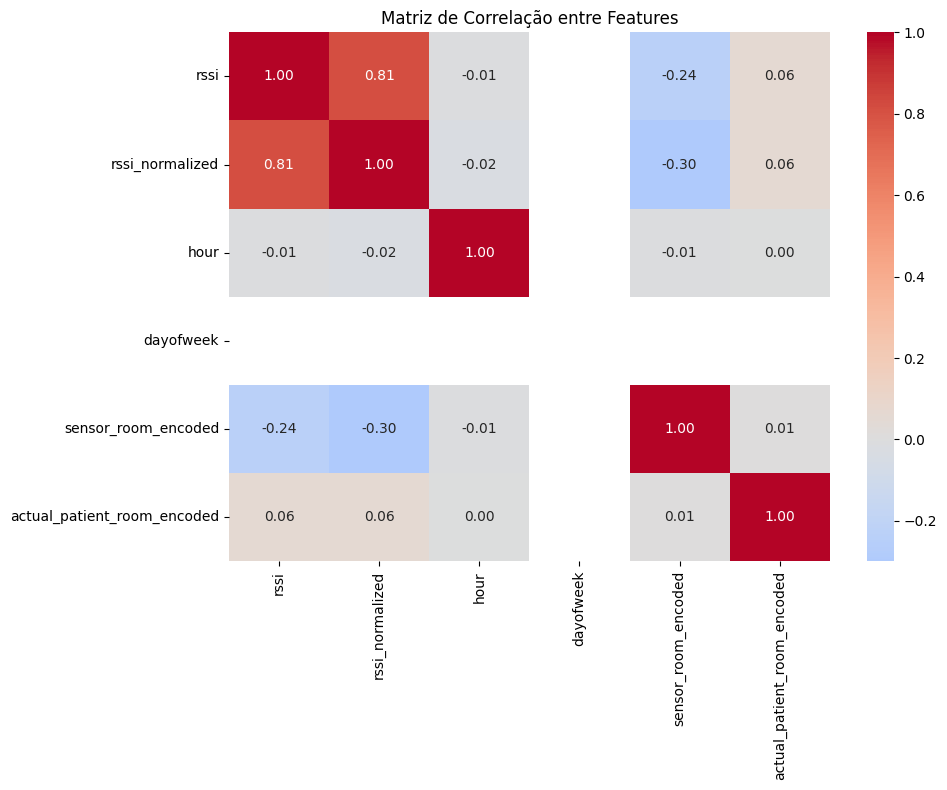


📊 Correlações com Target:
actual_patient_room_encoded    1.000000
rssi_normalized                0.061434
rssi                           0.059935
sensor_room_encoded            0.007882
hour                           0.000488
dayofweek                           NaN
Name: actual_patient_room_encoded, dtype: float64


In [5]:
# ============================================================================
# 4. ANÁLISE DE CORRELAÇÃO E FEATURE IMPORTANCE
# ============================================================================

print("\n" + "=" * 80)
print("3. ANÁLISE DE CORRELAÇÃO")
print("=" * 80)

# Selecionar features numéricas para correlação
numeric_cols = ['rssi', 'rssi_normalized', 'hour', 'dayofweek', 'sensor_room_encoded']
correlation_matrix = df_clean[numeric_cols + ['actual_patient_room_encoded']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação entre Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150)
plt.show()

print(f"\n📊 Correlações com Target:\n{correlation_matrix['actual_patient_room_encoded'].sort_values(ascending=False)}")


4. DISTRIBUIÇÃO DAS CLASSES (ROOMS)

📊 Distribuição de Rooms:
actual_patient_room
Quarto 2     2182
Quarto 1     2051
Corredor      291
Toalete       280
Arredores      52
Name: count, dtype: int64


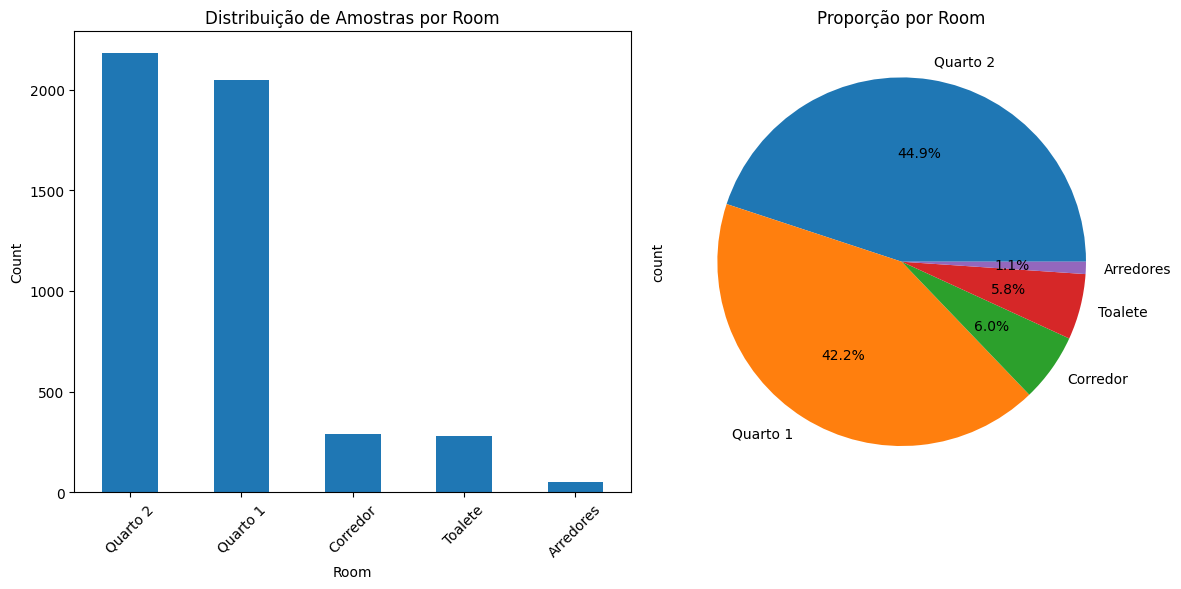

In [7]:
# ============================================================================
# 5. DISTRIBUIÇÃO DAS CLASSES (ROOMS)
# ============================================================================

print("\n" + "=" * 80)
print("4. DISTRIBUIÇÃO DAS CLASSES (ROOMS)")
print("=" * 80)

room_distribution = df_clean['actual_patient_room'].value_counts()
print(f"\n📊 Distribuição de Rooms:\n{room_distribution}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
room_distribution.plot(kind='bar')
plt.title('Distribuição de Amostras por Room')
plt.xlabel('Room')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
room_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Proporção por Room')
plt.tight_layout()
plt.savefig('room_distribution.png', dpi=150)
plt.show()

# 2. Desenvolvimento do Modelo

In [8]:
# ============================================================================
# 6. ESTRATÉGIA DE VALIDAÇÃO PARA NOVAS IMEIs
# ============================================================================

print("\n" + "=" * 80)
print("5. ESTRATÉGIA DE VALIDAÇÃO - GENERALIZAÇÃO PARA NOVOS IMEIs")
print("=" * 80)

# Estratégia: Leave-One-IMEI-Out Cross-Validation
# Isso garante que o modelo generalize para IMEIs não vistos no treino

unique_imeis = df_clean['imei'].unique()
print(f"\n📱 IMEIs únicos: {len(unique_imeis)}")
print(f"   {unique_imeis}")

# Para demonstração, vamos usar uma validação onde separamos um IMEI para teste
test_imei = 'IMEI_MOTO_G_OLD'  # Simulando novo dispositivo
train_df = df_clean[df_clean['imei'] != test_imei]
test_df = df_clean[df_clean['imei'] == test_imei]

print(f"\n📊 Split por IMEI:")
print(f"   Treino: {len(train_df)} amostras ({len(train_df)/len(df_clean)*100:.1f}%)")
print(f"   Teste (IMEI não visto): {len(test_df)} amostras ({len(test_df)/len(df_clean)*100:.1f}%)")


5. ESTRATÉGIA DE VALIDAÇÃO - GENERALIZAÇÃO PARA NOVOS IMEIs

📱 IMEIs únicos: 3
   ['IMEI_IPHONE_X' 'IMEI_SAMSUNG_S23' 'IMEI_MOTO_G_OLD']

📊 Split por IMEI:
   Treino: 3272 amostras (67.4%)
   Teste (IMEI não visto): 1584 amostras (32.6%)


In [9]:
# ============================================================================
# 7. FEATURE ENGINEERING
# ============================================================================

def create_features(df):
    """
    Criação de features para o modelo

    Features selecionadas:
    - rssi_normalized: RSSI normalizado por IMEI (CRÍTICO)
    - sensor_room_encoded: Sala do sensor (forte correlação)
    - hour: Hora do dia (padrões de movimento)
    - rssi_binned: RSSI categorizado (reduz ruído)
    """
    df_feat = df.copy()

    # RSSI Binning (reduz sensibilidade a ruídos)
    df_feat['rssi_binned'] = pd.cut(df_feat['rssi'],
                                     bins=[-120, -90, -70, -50, 0],
                                     labels=[0, 1, 2, 3])
    df_feat['rssi_binned'] = df_feat['rssi_binned'].astype(int)

    # Interação RSSI + Sensor Room
    df_feat['rssi_room_interaction'] = df_feat['rssi_normalized'] * df_feat['sensor_room_encoded']

    return df_feat

df_train = create_features(train_df)
df_test = create_features(test_df)

# Features para o modelo
feature_cols = ['rssi_normalized', 'sensor_room_encoded', 'hour',
                'rssi_binned', 'rssi_room_interaction']

X_train = df_train[feature_cols]
y_train = df_train['actual_patient_room_encoded']
X_test = df_test[feature_cols]
y_test = df_test['actual_patient_room_encoded']

print(f"\n✅ Features selecionadas: {feature_cols}")
print(f"   Shape Treino: {X_train.shape}")
print(f"   Shape Teste: {X_test.shape}")


✅ Features selecionadas: ['rssi_normalized', 'sensor_room_encoded', 'hour', 'rssi_binned', 'rssi_room_interaction']
   Shape Treino: (3272, 5)
   Shape Teste: (1584, 5)


In [10]:
# ============================================================================
# 8. TREINAMENTO DE MÚLTIPLOS MODELOS
# ============================================================================

print("\n" + "=" * 80)
print("6. TREINAMENTO E COMPARAÇÃO DE MODELOS")
print("=" * 80)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10,
                                           random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=6,
                                 learning_rate=0.1, random_state=42,
                                 use_label_encoder=False, eval_metric='mlogloss'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5,
                                                    random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n🔧 Treinando {name}...")
    model.fit(X_train, y_train)

    # Predições
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Métricas
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'gap': train_acc - test_acc  # Overfitting indicator
    }

    print(f"   📈 Acurácia Treino: {train_acc:.4f}")
    print(f"   📉 Acurácia Teste (Novo IMEI): {test_acc:.4f}")
    print(f"   ⚠️  Gap (Overfitting): {train_acc - test_acc:.4f}")

# Melhor modelo
best_model_name = max(results, key=lambda x: results[x]['test_acc'])
best_model = results[best_model_name]['model']
print(f"\n🏆 Melhor Modelo: {best_model_name}")
print(f"   Acurácia em Novo IMEI: {results[best_model_name]['test_acc']:.4f}")


6. TREINAMENTO E COMPARAÇÃO DE MODELOS

🔧 Treinando Random Forest...
   📈 Acurácia Treino: 0.7842
   📉 Acurácia Teste (Novo IMEI): 0.4444
   ⚠️  Gap (Overfitting): 0.3398

🔧 Treinando XGBoost...
   📈 Acurácia Treino: 0.6681
   📉 Acurácia Teste (Novo IMEI): 0.4773
   ⚠️  Gap (Overfitting): 0.1908

🔧 Treinando Gradient Boosting...
   📈 Acurácia Treino: 0.7958
   📉 Acurácia Teste (Novo IMEI): 0.4779
   ⚠️  Gap (Overfitting): 0.3179

🏆 Melhor Modelo: Gradient Boosting
   Acurácia em Novo IMEI: 0.4779



7. IMPORTÂNCIA DAS FEATURES

📊 Importância das Features:
                 feature  importance
4  rssi_room_interaction    0.444616
0        rssi_normalized    0.355672
2                   hour    0.100391
1    sensor_room_encoded    0.088289
3            rssi_binned    0.011032


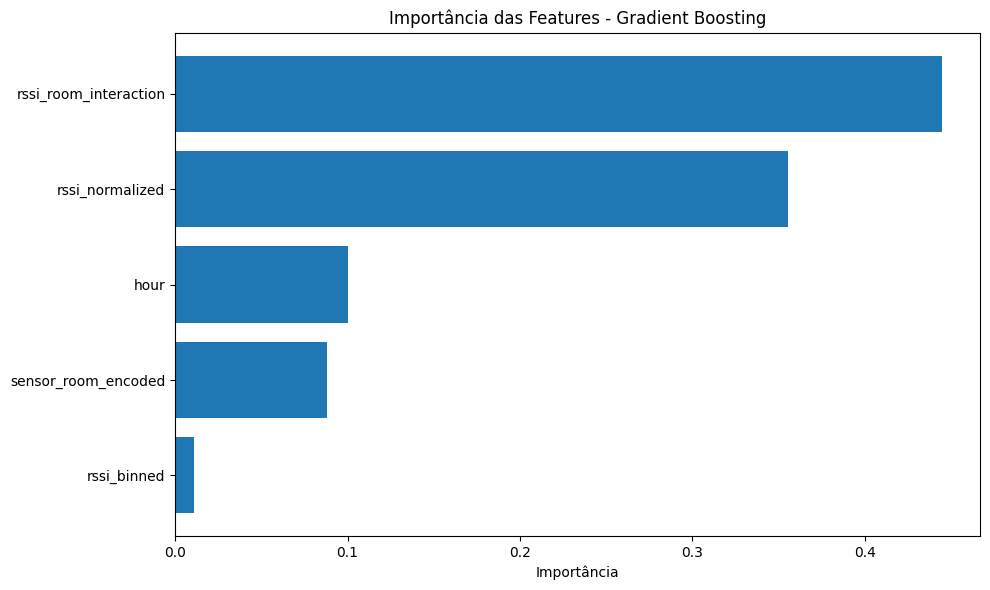

In [11]:
# ============================================================================
# 9. FEATURE IMPORTANCE
# ============================================================================

print("\n" + "=" * 80)
print("7. IMPORTÂNCIA DAS FEATURES")
print("=" * 80)

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n📊 Importância das Features:\n{feature_importance}")

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Importância')
    plt.title('Importância das Features - ' + best_model_name)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150)
    plt.show()


8. MATRIZ DE CONFUSÃO


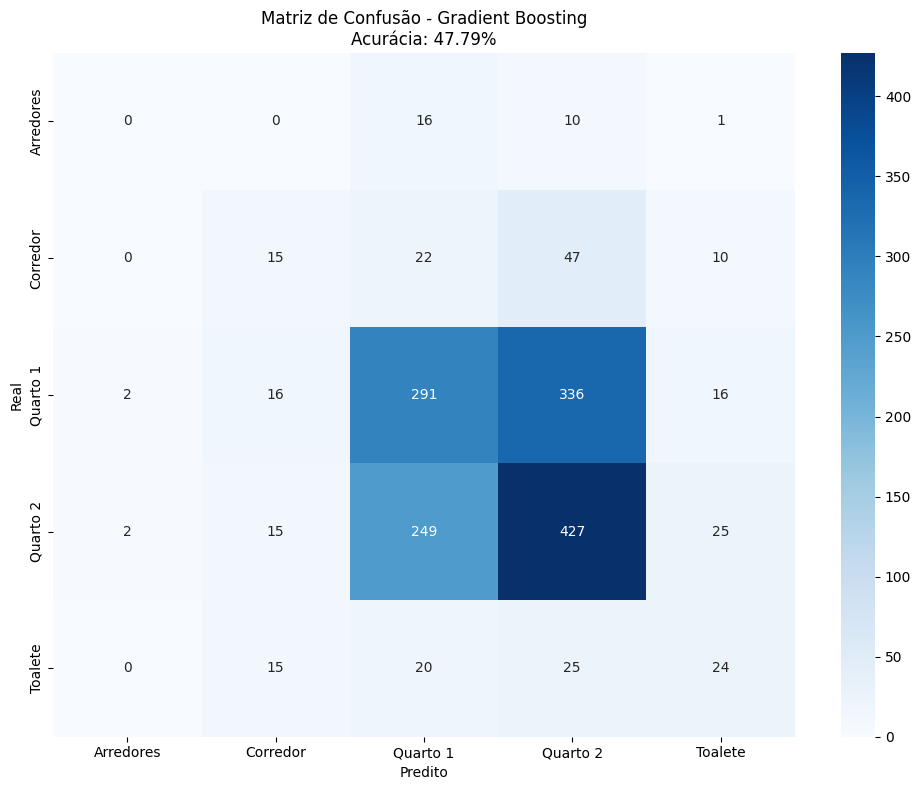


📋 Classification Report:
              precision    recall  f1-score   support

   Arredores       0.00      0.00      0.00        27
    Corredor       0.25      0.16      0.19        94
    Quarto 1       0.49      0.44      0.46       661
    Quarto 2       0.51      0.59      0.55       718
     Toalete       0.32      0.29      0.30        84

    accuracy                           0.48      1584
   macro avg       0.31      0.30      0.30      1584
weighted avg       0.46      0.48      0.47      1584



In [12]:
# ============================================================================
# 10. MATRIZ DE CONFUSÃO
# ============================================================================

print("\n" + "=" * 80)
print("8. MATRIZ DE CONFUSÃO")
print("=" * 80)

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - {best_model_name}\nAcurácia: {results[best_model_name]["test_acc"]:.2%}')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

print(f"\n📋 Classification Report:\n{classification_report(y_test, y_pred_best, target_names=le_target.classes_)}")